In [1]:
import numpy as np
import pandas as pd
import scipy as sp
from collections import OrderedDict
from tqdm import tqdm
from typing import Dict

import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Embedding, Flatten, Input, Lambda
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_pickle('../datasets/clean_df.csv', compression='zip')

In [3]:
# Convert user id and song id to numerical ids
df['user_id'] = df['user'].astype('category').cat.codes
df['song_id'] = df['song'].astype('category').cat.codes

df_orig = df.copy()

# Create lookup frame so we can get the 'Song - Artist' later
item_lookup = df[['song_id','Song - Artist']].drop_duplicates()
item_lookup['song_id'] = item_lookup['song_id'].astype(str)

# Drop 'user' and 'song' and 'Song - Artist'
df = df.drop(['user','song','Song - Artist'], axis=1)

df = df.sort_values(by=['user_id', 'song_id'])

aggd = df.groupby('user_id')['song_id'].agg(list).reset_index()
nuser_listens = {row['user_id'] : row['song_id'] for _ , row in aggd.iterrows()}

# Create lists of all unique users, songs
uusers = list(np.sort(df['user_id'].unique()))
usongs = list(np.sort(df['song_id'].unique()))
nusers = len(uusers)
nsongs = len(usongs)

### Validation hold-out

In [4]:
tmp_val = (
        df.groupby('user_id')['song_id'].count()
    ).reset_index().rename({'song_id':'records'}, axis=1)
tmp_val.shape

(418252, 2)

In [5]:
min_records = 3
conditions = df['user_id'].isin(tmp_val[tmp_val['records'] > min_records].user_id)
df_val = df[conditions].groupby('user_id').head(1).reset_index()
del df_val['index']
df_val.shape

(41355, 3)

In [6]:
ground_truth = { row.user_id : row.song_id for _ , row in df_val.iterrows() }
df_train = pd.concat([df, df_val]).drop_duplicates(keep=False)

### Building Triplets

In [7]:
%%time

data = []
n_random_samples = 2

uusers_train = list(df_train['user_id'].unique())

for user in tqdm( uusers_train ):
    listened = df_train[df_train['user_id'] == user]['song_id'].values
    
    for i in listened:
        cnt = 0
        while ( cnt < n_random_samples ):
            j = df_train.sample(1).iloc[0,2]
            if ( j not in listened ):
                data.append({
                    'u' : user,
                    'i' : i,
                    'j' : j
                })
                cnt += 1

ttriplets = pd.DataFrame(data, columns=['u', 'i', 'j'])

100%|██████████| 418252/418252 [8:46:47<00:00, 13.23it/s]   


CPU times: user 8h 20min 4s, sys: 12min 44s, total: 8h 32min 48s
Wall time: 8h 46min 50s


In [14]:
ttriplets.to_pickle('../datasets/ttriplets_LOCAL_PICKLE.csv', compression='zip')

In [15]:
ttriplets.to_csv('../datasets/ttriplets_LOCAL.csv', compression='zip', sep='\t')

In [8]:
X = {
    'user_input': tf.convert_to_tensor(ttriplets.u),
    'positive_item_input': tf.convert_to_tensor(ttriplets.i),
    'negative_item_input': tf.convert_to_tensor(ttriplets.j)
}

### Build model

In [9]:
@tf.function
def identity_loss(_, y_pred):
    return tf.math.reduce_mean(y_pred)

@tf.function
def triplet_loss(X: dict):
    i_latent , j_latent , u_latent = X
    pos_interactions = tf.math.reduce_sum(tf.math.multiply(u_latent, i_latent), axis=-1, keepdims=True)
    neg_interactions = tf.math.reduce_sum(tf.math.multiply(u_latent, j_latent), axis=-1, keepdims=True)
    return tf.math.subtract(tf.constant(1.0), tf.sigmoid(tf.math.subtract(pos_interactions, neg_interactions)))

def out_shape(shapes):
    return shapes[0]

In [10]:
def build_model(num_users: int, num_items: int, latent_dim: int) -> Model:
    u_input = Input((1,), name='user_input')
    i_input = Input((1,), name='positive_item_input')
    j_input = Input((1,), name='negative_item_input')
    
    item_emb = Embedding(num_items, latent_dim, name='item_embedding', input_length=1)
    i_emb = Flatten()( item_emb(i_input) )
    j_emb = Flatten()( item_emb(j_input) )
    
    u_emb = Embedding(num_users, latent_dim, name='user_embedding', input_length=1)(u_input)
    u_emb = Flatten()(u_emb)
    
    t_loss = Lambda(triplet_loss, output_shape=out_shape, name='triplet_loss')([i_emb, j_emb, u_emb])
    
    model = Model(inputs=[i_input, j_input, u_input], outputs=t_loss)
    
    return model

#### Functions used to evaluate the models

In [11]:
def get_weights(model: Model, song_ids: list):
    u = model.get_layer('user_embedding').get_weights()[0]
    i = model.get_layer('item_embedding').get_weights()[0][song_ids]
    return u, i

def get_topk(model, user, usongs, weights, k=10):
    user_weights, item_weights = weights
    
    user_vector = user_weights[user]
    item_matrix = item_weights
    
    scores = np.dot(user_vector, item_matrix.T)
    
    predictions = dict(zip(usongs,scores))
    predictions = sorted(predictions.items(), key=lambda kv:kv[1], reverse=True)[:k]
    predictions = list(OrderedDict(predictions).keys())
    
    return predictions

def get_hits(user_listens, user_recs):
    hits = 0
    for song in user_listens:
        if ( song in user_recs ):
            hits += 1
    return hits

def get_metrics(uusers: list, nuser_listens: dict, nuser_recs: dict, N: int, k=10):
    nusers = len(uusers)
    precision = recall = t_hits = 0
    
    for user in tqdm(uusers, desc='Getting metrics... '):
        hits = get_hits(user_listens=nuser_listens[user], user_recs=nuser_recs[user])
        precision += hits / len(nuser_listens[user])
        recall += hits / k
        t_hits += hits
                                
    precision = precision / nusers
    recall = recall / nusers
    hit_ratio = t_hits / N
    
    return precision, recall, hit_ratio

def hold_out_hit_ratio(ground_truth: dict, nuser_recs: dict):
    hits = 0
    for _ , (user , song) in enumerate(ground_truth.items()):
        if song in nuser_recs[user]:
            hits += 0
    return hits / (len(ground_truth) if len(ground_truth) > 0 else 1)

def evaluate(model: Model, uusers: list, usongs: list, nuser_listens: dict, N: int, ground_truth=None, k=10):
    weights = get_weights(model, usongs)
    nuser_recs = {user : get_topk(model=model, user=user, usongs=usongs, weights=weights) for user in tqdm(uusers, desc='Generating recommendations for all users... ')}
    p , r , hr = get_metrics(uusers=uusers, nuser_listens=nuser_listens, nuser_recs=nuser_recs, N=N)
    hoh = hold_out_hit_ratio(ground_truth, nuser_recs)
        
    evals = {
        'precision' : p,
        'recall' : r,
        'hit_ratio' : hr,
        'hold_out_hits': hoh
    }
    return evals

In [12]:
#---------------
#  HYPERPARAMS
#---------------
latent_dims = [200, 250, 300, 350]
batch_size = 512
epochs = 3
learning_rates = [0.01, 0.01, 0.1]

In [13]:
model_hist = []
for latent_dim in latent_dims:
    for learning_rate in learning_rates:
        print('++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++')
        print(f'LATENT DIMENSIONS: {latent_dim}. LEARNING_RATE: {learning_rate}')
        model = build_model(nusers, nsongs, latent_dim)
        model.compile(loss=identity_loss, optimizer=Adam(learning_rate))
        model.fit(X, tf.ones(ttriplets.shape[0]), batch_size, verbose=1, epochs=epochs)
        evals = evaluate(model=model, uusers=uusers, usongs=usongs, nuser_listens=nuser_listens, ground_truth=ground_truth, N=df.shape[0])
        print(evals)
        model_hist.append({
            'latent_dim' : latent_dim,
            'learning_rate' : learning_rate,
            'precision' : evals['precision'],
            'recall' : evals['recall'],
            'hit_ratio' : evals['hit_ratio'],
            'hold_out_hits' : evals['hold_out_hits']
        })

++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
LATENT DIMENSIONS: 200. LEARNING_RATE: 0.01
Epoch 1/3
  40/2857 [..............................] - ETA: 1:10:00 - loss: 0.4996

KeyboardInterrupt: 

In [ ]:
pd.DataFrame(model_hist)

In [20]:
results = [
    {
        'latent_dim' : 200,
        'learning_rate' : 0.001,
        'precision' : 0.9007733868363252,
        'recall' : 0.1580288916722781,
        'hit_ratio' : 0.85543207176239,
        'hold_out_hits' : 0.0
    },
    {
        'latent_dim' : 200,
        'learning_rate' : 0.01,
        'precision' : 0.965031453031885,
        'recall' : 0.1688926771415658,
        'hit_ratio' : 0.9142392329883351,
        'hold_out_hits' : 0.0
    },
    {
        'latent_dim' : 200,
        'learning_rate' : 0.1,
        'precision' : 0.6523921812302971,
        'recall' : 0.09435077417386167,
        'hit_ratio' : 0.5107336852772432,
        'hold_out_hits' : 0.0
    },
]

df_results = pd.DataFrame(results)

In [26]:
df_results

,latent_dim,learning_rate,precision,recall,hit_ratio,hold_out_hits
0,200,0.001,0.900773,0.158029,0.855432,0.0
1,200,0.010,0.965031,0.168893,0.914239,0.0
2,200,0.100,0.652392,0.094351,0.510734,0.0


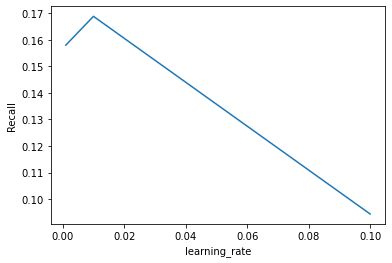

In [33]:
plt.plot(df_results['learning_rate'], df_results['recall'])
# plt.title('Latent Dimensions')
plt.xlabel('learning_rate')
plt.ylabel('Recall')
plt.show()